# Semantic Code Search using Transformers - Part I 
by:
### Maj Ashish Ahluwalia (21111073) ashisha21@iitk.ac.in
### Binay Kumar Suna (21111021) binayas21@iitk.ac.in
### Chabil Kansal (21111022) chabilk21@iitk.ac.in
### Shubham Sinha (21111409) shubhams21@iitk.ac.in


In [59]:
# Mount your drive which contains the CS657 IR PROJECT folder containing the data ("python folder")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install astor

In [60]:
#importing libraries

import ast
import sqlite3

import glob
import re
import numpy as np
from pathlib import Path
import os
import json


import astor
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

In [64]:
data_list = os.listdir("drive/MyDrive/CS657 IR PROJECT/python/jsonl/complete/")
# data_list
df = pd.DataFrame(columns=['nwo','path','function_name','original_function','function_tokens','docstring_tokens','url'])
# df
data_list

['python_train_0.jsonl',
 'python_train_1.jsonl',
 'python_train_2.jsonl',
 'python_train_3.jsonl',
 'python_train_4.jsonl',
 'python_train_5.jsonl',
 'python_train_6.jsonl',
 'python_train_7.jsonl',
 'python_train_8.jsonl',
 'python_train_9.jsonl',
 'python_train_10.jsonl',
 'python_train_11.jsonl',
 'python_train_12.jsonl',
 'python_train_13.jsonl',
 'python_valid_0.jsonl',
 'python_test_0.jsonl']

In [65]:
list_of_dict = []
d = {}
for file in data_list[:7]:
    with open('drive/MyDrive/CS657 IR PROJECT/python/jsonl/complete/' + file, 'r') as json_file:
        json_list = list(json_file)
    for json_str in json_list:
        result = json.loads(json_str)
        list_of_dict.append(result)
    print(file)
    print(len(json_list))
i = 0
print("Out")
for entry in list_of_dict:
    d[i] = {'nwo':str(entry['path']).split('/')[-1],
                  'path':entry['path'],
                  'function_name':entry['func_name'],
                  'content':entry['code'],
                  'docstring_tokens':' '.join(entry['docstring_tokens']),
                  'url':entry['url']}
    i = i + 1

df = pd.DataFrame.from_dict(d,"index")
df

python_train_0.jsonl
30000
python_train_1.jsonl
30000
python_train_2.jsonl
30000
python_train_3.jsonl
30000
python_train_4.jsonl
30000
python_train_5.jsonl
30000
python_train_6.jsonl
30000
Out


,nwo,path,function_name,content,docstring_tokens,url
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,"def train(train_dir, model_save_path=None, n_n...",Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,"def predict(X_img_path, knn_clf=None, model_pa...",Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,"def show_prediction_labels_on_image(img_path, ...",Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...
3,api.py,face_recognition/api.py,_rect_to_css,"def _rect_to_css(rect):\n """"""\n Convert ...",Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...
4,api.py,face_recognition/api.py,_trim_css_to_bounds,"def _trim_css_to_bounds(css, image_shape):\n ...",Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...
...,...,...,...,...,...,...
209995,folia.py,pynlpl/formats/folia.py,AbstractElement.speech_speaker,"def speech_speaker(self):\n """"""Retrieve...",Retrieves the speaker of the audio or video fi...,https://github.com/proycon/pynlpl/blob/7707f69...
209996,folia.py,pynlpl/formats/folia.py,AbstractElement.phon,"def phon(self, cls='current', previousdelimite...",Get the phonetic representation associated wit...,https://github.com/proycon/pynlpl/blob/7707f69...
209997,folia.py,pynlpl/formats/folia.py,AbstractElement.feat,"def feat(self,subset):\n """"""Obtain the ...",Obtain the feature class value of the specific...,https://github.com/proycon/pynlpl/blob/7707f69...
209998,folia.py,pynlpl/formats/folia.py,AbstractElement.copy,"def copy(self, newdoc=None, idsuffix=""""):\n ...",Make a deep copy of this element and all its c...,https://github.com/proycon/pynlpl/blob/7707f69...


In [69]:
def tokenize_docstring(text):
    """Gets filetered docstring tokens which help describe the function"""
    
    # Remove decorators and other parameter signatures in the docstring
    before_keyword, keyword, after_keyword = text.partition(':')
    before_keyword, keyword, after_keyword = before_keyword.partition('@param')
    before_keyword, keyword, after_keyword = before_keyword.partition('param')
    before_keyword, keyword, after_keyword = before_keyword.partition('@brief')
    
    if(after_keyword):    
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    else:
        before_keyword, keyword, after_keyword = before_keyword.partition('@')
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(before_keyword)
        
    # Convert all docstrings to lowercase
    new_words= [word.lower() for word in words if word.isalnum()]
    
    return new_words


def tokenize_code(text):
    """Gets filetered fucntion tokens"""
    
    # Remove decorators and function signatures till the def token
    keyword = 'def '
    before_keyword, keyword, after_keyword = text.partition(keyword)
    words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    
    # Convert function tokens to lowercase and remove single alphabet variables
    new_words= [word.lower() for word in words if (word.isalpha() and len(word)>1) or (word.isnumeric())]
    return new_words


def get_function_docstring_pairs(blob):
    "Extracts (function/method, docstring) pairs from a given code blob."
    
    pairs = []
    try:
        module = ast.parse(blob) # Converts the python code into an abstract syntx tree
        classes = [node for node in module.body if isinstance(node, ast.ClassDef)] # Retrieves classes from source code
        functions = [node for node in module.body if isinstance(node, ast.FunctionDef)] # Retrieves functions from the source code
        for _class in classes:
            functions.extend([node for node in _class.body if isinstance(node, ast.FunctionDef)]) # Retrieves functions from the classes extracted

        for f in functions:
            source = astor.to_source(f) # Convert the functions extracted into ast format so as to remove comments
            docstring = ast.get_docstring(f) if ast.get_docstring(f) else '' # Get docstring from fucntion definition if present
            function = source.replace(ast.get_docstring(f, clean=False), '') if docstring else source # function definition without any comments
            
            # Extracts function name, line number of the function in the source code, original function, function tokens and docstring tokens 
            pairs.append((f.name,         
                          f.lineno,
                          source,
                          ' '.join(tokenize_code(function)),
                          ' '.join(tokenize_docstring(docstring.split('\n\n')[0]))
                         ))
    except (AssertionError, MemoryError, SyntaxError, UnicodeEncodeError):
        pass
    return pairs


def get_function_docstring_pairs_list(blob_list):
    """apply the function `get_function_docstring_pairs` on a list of blobs"""
    return [get_function_docstring_pairs(b) for b in blob_list]

In [70]:
x = df.content.tolist()

In [71]:
func_doc = get_function_docstring_pairs_list(df.content.tolist())

In [72]:
len(func_doc) 

210000

In [73]:
# The dataset containing a the name of the directory, its path, source code, and all the functions in a list extracted from the source code
df['pairs'] = func_doc
df.head()

,nwo,path,function_name,content,docstring_tokens,url,pairs
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,"def train(train_dir, model_save_path=None, n_n...",Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...,"[(train, 1, def train(train_dir, model_save_pa..."
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,"def predict(X_img_path, knn_clf=None, model_pa...",Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...,"[(predict, 1, def predict(X_img_path, knn_clf=..."
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,"def show_prediction_labels_on_image(img_path, ...",Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...,"[(show_prediction_labels_on_image, 1, def show..."
3,api.py,face_recognition/api.py,_rect_to_css,"def _rect_to_css(rect):\n """"""\n Convert ...",Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...,"[(_rect_to_css, 1, def _rect_to_css(rect):\n ..."
4,api.py,face_recognition/api.py,_trim_css_to_bounds,"def _trim_css_to_bounds(css, image_shape):\n ...",Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...,"[(_trim_css_to_bounds, 1, def _trim_css_to_bou..."


In [74]:
%%time
# flatten pairs
df = df.set_index(['nwo', 'path','function_name','content', 'docstring_tokens', 'url'])['pairs'].apply(pd.Series).stack()
df

CPU times: user 1min 1s, sys: 2.76 s, total: 1min 4s
Wall time: 1min 1s


In [75]:
df = df.reset_index()
df

,nwo,path,function_name,content,docstring_tokens,url,level_6,0
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,"def train(train_dir, model_save_path=None, n_n...",Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...,0,"(train, 1, def train(train_dir, model_save_pat..."
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,"def predict(X_img_path, knn_clf=None, model_pa...",Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...,0,"(predict, 1, def predict(X_img_path, knn_clf=N..."
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,"def show_prediction_labels_on_image(img_path, ...",Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...,0,"(show_prediction_labels_on_image, 1, def show_..."
3,api.py,face_recognition/api.py,_rect_to_css,"def _rect_to_css(rect):\n """"""\n Convert ...",Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...,0,"(_rect_to_css, 1, def _rect_to_css(rect):\n ..."
4,api.py,face_recognition/api.py,_trim_css_to_bounds,"def _trim_css_to_bounds(css, image_shape):\n ...",Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...,0,"(_trim_css_to_bounds, 1, def _trim_css_to_boun..."
...,...,...,...,...,...,...,...,...
206174,folia.py,pynlpl/formats/folia.py,AbstractElement.speech_speaker,"def speech_speaker(self):\n """"""Retrieve...",Retrieves the speaker of the audio or video fi...,https://github.com/proycon/pynlpl/blob/7707f69...,0,"(speech_speaker, 1, def speech_speaker(self):\..."
206175,folia.py,pynlpl/formats/folia.py,AbstractElement.phon,"def phon(self, cls='current', previousdelimite...",Get the phonetic representation associated wit...,https://github.com/proycon/pynlpl/blob/7707f69...,0,"(phon, 1, def phon(self, cls='current', previo..."
206176,folia.py,pynlpl/formats/folia.py,AbstractElement.feat,"def feat(self,subset):\n """"""Obtain the ...",Obtain the feature class value of the specific...,https://github.com/proycon/pynlpl/blob/7707f69...,0,"(feat, 1, def feat(self, subset):\n """"""Obta..."
206177,folia.py,pynlpl/formats/folia.py,AbstractElement.copy,"def copy(self, newdoc=None, idsuffix=""""):\n ...",Make a deep copy of this element and all its c...,https://github.com/proycon/pynlpl/blob/7707f69...,0,"(copy, 1, def copy(self, newdoc=None, idsuffix..."


In [76]:
df.columns = ['nwo', 'path','function_name','content', 'docstring_tokens', 'url', '_', 'pair']

In [77]:
df.head()

,nwo,path,function_name,content,docstring_tokens,url,_,pair
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,"def train(train_dir, model_save_path=None, n_n...",Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...,0,"(train, 1, def train(train_dir, model_save_pat..."
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,"def predict(X_img_path, knn_clf=None, model_pa...",Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...,0,"(predict, 1, def predict(X_img_path, knn_clf=N..."
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,"def show_prediction_labels_on_image(img_path, ...",Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...,0,"(show_prediction_labels_on_image, 1, def show_..."
3,api.py,face_recognition/api.py,_rect_to_css,"def _rect_to_css(rect):\n """"""\n Convert ...",Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...,0,"(_rect_to_css, 1, def _rect_to_css(rect):\n ..."
4,api.py,face_recognition/api.py,_trim_css_to_bounds,"def _trim_css_to_bounds(css, image_shape):\n ...",Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...,0,"(_trim_css_to_bounds, 1, def _trim_css_to_boun..."


In [78]:
%%time
df['lineno'] = df['pair'].apply(lambda p: p[1])
df['original_function'] = df['content']
df['function_tokens'] = df['pair'].apply(lambda p: p[3])
df = df[['nwo', 'path', 'function_name', 'lineno', 'original_function', 'function_tokens', 'docstring_tokens', 'url']]

CPU times: user 380 ms, sys: 6.55 ms, total: 387 ms
Wall time: 388 ms


In [79]:
df.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,1,"def train(train_dir, model_save_path=None, n_n...",train train dir model save path none neighbors...,Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,1,"def predict(X_img_path, knn_clf=None, model_pa...",predict img path knn clf none model path none ...,Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,1,"def show_prediction_labels_on_image(img_path, ...",show prediction labels on image img path predi...,Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...
3,api.py,face_recognition/api.py,_rect_to_css,1,"def _rect_to_css(rect):\n """"""\n Convert ...",rect to css rect return rect top rect right re...,Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...
4,api.py,face_recognition/api.py,_trim_css_to_bounds,1,"def _trim_css_to_bounds(css, image_shape):\n ...",trim css to bounds css image shape return max ...,Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...


In [83]:
%%time
# remove observations where the same function definition appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['original_function'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 0 duplicate rows
CPU times: user 775 ms, sys: 8.73 ms, total: 784 ms
Wall time: 790 ms


In [84]:
%%time
# remove observations which have the same function tokens appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['function_tokens'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 221 duplicate rows
CPU times: user 376 ms, sys: 7.81 ms, total: 384 ms
Wall time: 382 ms


In [85]:
df.shape

(205958, 8)

### Separate function without docstrings


In [86]:
def listlen(x):
    if not isinstance(x, list):
        return 0
    return len(x)

# separate functions without docstrings
# docstrings should be at least 3 words in the docstring to be considered a valid docstring

with_docstrings = df[df.docstring_tokens.str.split().apply(listlen) >= 3]
without_docstrings = df[df.docstring_tokens.str.split().apply(listlen) < 3]
print('Number of Funtion Snippets with docstring',len(with_docstrings))
print('Number of Funtion Snippets without docstring',len(without_docstrings))

Number of Funtion Snippets with docstring 202906
Number of Funtion Snippets without docstring 3052


In [87]:
# Save the dataset of functions with docstrings
with_docstrings.to_csv('drive/MyDrive/CS657 IR PROJECT/processed_full.csv')

In [ ]:
# Using SQLlite to analyse the dataset
conn = sqlite3.connect('drive/MyDrive/CS657 IR PROJECT/with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
with_docstrings.to_sql('Data', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [89]:
with_docstrings.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,1,"def train(train_dir, model_save_path=None, n_n...",train train dir model save path none neighbors...,Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,1,"def predict(X_img_path, knn_clf=None, model_pa...",predict img path knn clf none model path none ...,Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,1,"def show_prediction_labels_on_image(img_path, ...",show prediction labels on image img path predi...,Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...
3,api.py,face_recognition/api.py,_rect_to_css,1,"def _rect_to_css(rect):\n """"""\n Convert ...",rect to css rect return rect top rect right re...,Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...
4,api.py,face_recognition/api.py,_trim_css_to_bounds,1,"def _trim_css_to_bounds(css, image_shape):\n ...",trim css to bounds css image shape return max ...,Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...


In [90]:
# Number of unique repositories
print("Number of repositories -",len(list(set(with_docstrings['nwo']))))

Number of repositories - 21420


In [91]:
with_docstrings['function_tokens_count'] = [len(item.split()) for item in list(with_docstrings['function_tokens'].values)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
with_docstrings

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,face_recognition_knn.py,examples/face_recognition_knn.py,train,1,"def train(train_dir, model_save_path=None, n_n...",train train dir model save path none neighbors...,Trains a k - nearest neighbors classifier for ...,https://github.com/ageitgey/face_recognition/b...,168
1,face_recognition_knn.py,examples/face_recognition_knn.py,predict,1,"def predict(X_img_path, knn_clf=None, model_pa...",predict img path knn clf none model path none ...,Recognizes faces in given image using a traine...,https://github.com/ageitgey/face_recognition/b...,157
2,face_recognition_knn.py,examples/face_recognition_knn.py,show_prediction_labels_on_image,1,"def show_prediction_labels_on_image(img_path, ...",show prediction labels on image img path predi...,Shows the face recognition results visually .,https://github.com/ageitgey/face_recognition/b...,87
3,api.py,face_recognition/api.py,_rect_to_css,1,"def _rect_to_css(rect):\n """"""\n Convert ...",rect to css rect return rect top rect right re...,Convert a dlib rect object to a plain tuple in...,https://github.com/ageitgey/face_recognition/b...,13
4,api.py,face_recognition/api.py,_trim_css_to_bounds,1,"def _trim_css_to_bounds(css, image_shape):\n ...",trim css to bounds css image shape return max ...,Make sure a tuple in ( top right bottom left )...,https://github.com/ageitgey/face_recognition/b...,28
...,...,...,...,...,...,...,...,...,...
206174,folia.py,pynlpl/formats/folia.py,AbstractElement.speech_speaker,1,"def speech_speaker(self):\n """"""Retrieve...",speech speaker self if self speaker return sel...,Retrieves the speaker of the audio or video fi...,https://github.com/proycon/pynlpl/blob/7707f69...,20
206175,folia.py,pynlpl/formats/folia.py,AbstractElement.phon,1,"def phon(self, cls='current', previousdelimite...",phon self cls current previousdelimiter strict...,Get the phonetic representation associated wit...,https://github.com/proycon/pynlpl/blob/7707f69...,88
206176,folia.py,pynlpl/formats/folia.py,AbstractElement.feat,1,"def feat(self,subset):\n """"""Obtain the ...",feat self subset none for in self if isinstanc...,Obtain the feature class value of the specific...,https://github.com/proycon/pynlpl/blob/7707f69...,30
206177,folia.py,pynlpl/formats/folia.py,AbstractElement.copy,1,"def copy(self, newdoc=None, idsuffix=""""):\n ...",copy self newdoc none idsuffix if idsuffix is ...,Make a deep copy of this element and all its c...,https://github.com/proycon/pynlpl/blob/7707f69...,24


In [ ]:
# Using SQLlite to analyse the dataset
conn = sqlite3.connect('drive/MyDrive/CS657 IR PROJECT/with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
with_docstrings.to_sql('Data', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

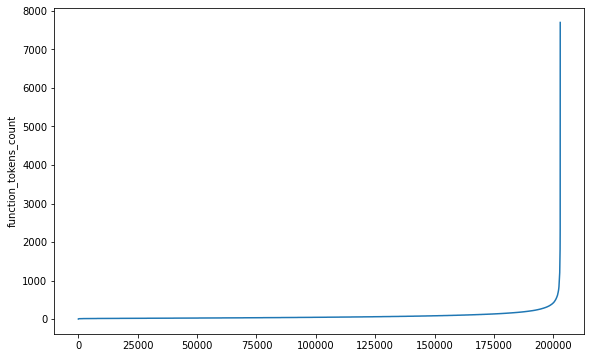

In [97]:
import matplotlib.pyplot as plt
# Plotting the graph of sorted list of function tokens
plt.plot(sorted(list(with_docstrings['function_tokens_count'] .values)))
plt.ylabel('function_tokens_count')
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.show()

In [ ]:
# Analysing what must be the minimum count of function tokens by seeing the values returned in sql queries
final = pd.read_sql_query("""
SELECT *
FROM Data
WHERE function_tokens_count>4
ORDER BY function_tokens_count
""", conn)
final[:20]

In [ ]:
final.shape

In [100]:
conn = sqlite3.connect('drive/MyDrive/CS657 IR PROJECT/with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Modified', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [101]:
# checking if functions which are overridden are of importance to us
check = pd.read_sql_query("""
SELECT *
FROM Modified
WHERE function_name LIKE '!_!_%' ESCAPE'!'
ORDER BY function_tokens_count
""", conn)
check.head()

,level_0,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,1628,143433,unpy2exe.py,unpy2exe.py,__timestamp,1,"def __timestamp():\n """"""Generate timestamp ...",timestamp today time time ret struct pack int ...,Generate timestamp data for pyc header .,https://github.com/matiasb/unpy2exe/blob/7a579...,11
1,2471,92147,pytango_pprint.py,tango/pytango_pprint.py,__struct_params_str,1,"def __struct_params_str(obj, fmt, f=repr):\n ...",struct params str obj fmt repr return struct p...,method wrapper for printing all elements of a ...,https://github.com/tango-controls/pytango/blob...,12
2,2832,137370,easygui.py,src/canari/easygui.py,__buttonEvent,1,"def __buttonEvent(event):\n """"""\n Handle...",buttonevent event global boxroot widgettexts r...,Handle an event that is generated by a person ...,https://github.com/redcanari/canari3/blob/322d...,12
3,7457,185484,__init__.py,iotilebuild/iotile/build/config/scons-local-3....,__ensure_suffix,1,"def __ensure_suffix(t, suffix):\n """""" Ensur...",ensure suffix suffix tpath str if not tpath en...,Ensure that the target t has the given suffix .,https://github.com/iotile/coretools/blob/2d794...,14
4,8942,95349,connect.py,pyVim/connect.py,__Logout,1,"def __Logout(si):\n """"""\n Disconnect (logo...",logout si try if si content si retrievecontent...,Disconnect ( logout ) service instance,https://github.com/vmware/pyvmomi/blob/3ffcb23...,15


In [102]:
final.to_csv('drive/MyDrive/CS657 IR PROJECT/processed_full2.csv')

In [103]:
#Grouping entries by thie repository name
grouped = final.groupby('nwo')

In [104]:
# train, valid, test splits
train, valid = train_test_split(list(grouped), train_size=0.9, random_state=8081)
train, test = train_test_split(train, train_size=0.9, random_state=8081)

In [105]:
train = pd.concat([d for _, d in train]).reset_index(drop=True)
valid = pd.concat([d for _, d in valid]).reset_index(drop=True)
test = pd.concat([d for _, d in test]).reset_index(drop=True)

In [108]:
print(f'train set num rows {train.shape[0]:,}')
print(f'valid set num rows {valid.shape[0]:,}')
print(f'test set num rows {test.shape[0]:,}')
print(f'without docstring rows {without_docstrings.shape[0]:,}')

train set num rows 161,098
valid set num rows 24,469
test set num rows 17,313
without docstring rows 3,052


In [109]:
train.head()

,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,97295,gandi.py,lexicon/providers/gandi.py,GandiRPCSubProvider.authenticate,1,"def authenticate(self):\n """"""Determine ...",authenticate self try payload self api domain ...,Determine the current domain and zone IDs for ...,https://github.com/AnalogJ/lexicon/blob/9330b8...,35
1,97296,gandi.py,lexicon/providers/gandi.py,GandiRPCSubProvider.create_record,1,"def create_record(self, rtype, name, content, ...",create record self rtype name content ttl vers...,Creates a record for the domain in a new Gandi...,https://github.com/AnalogJ/lexicon/blob/9330b8...,91
2,97294,gandi.py,lexicon/providers/gandi.py,Provider._update_record,1,"def _update_record(self, identifier, rtype=Non...",update record self identifier rtype none name ...,Updates the specified record in a new Gandi zone,https://github.com/AnalogJ/lexicon/blob/9330b8...,112
3,97297,gandi.py,lexicon/providers/gandi.py,GandiRPCSubProvider.list_records,1,"def list_records(self, rtype=None, name=None, ...",list records self rtype none name none content...,List all record for the domain in the active G...,https://github.com/AnalogJ/lexicon/blob/9330b8...,113
4,97299,gandi.py,lexicon/providers/gandi.py,GandiRPCSubProvider.delete_record,1,"def delete_record(self, identifier=None, rtype...",delete record self identifier none rtype none ...,Removes the specified records in a new Gandi z...,https://github.com/AnalogJ/lexicon/blob/9330b8...,173


In [110]:
train.sort_values(by=['function_tokens_count'], inplace=True)
valid.sort_values(by=['function_tokens_count'], inplace=True)
test.sort_values(by=['function_tokens_count'], inplace=True)

In [111]:
train.to_csv('drive/MyDrive/CS657 IR PROJECT/train_sorted.csv')
valid.to_csv('drive/MyDrive/CS657 IR PROJECT/valid_sorted.csv')
test.to_csv('drive/MyDrive/CS657 IR PROJECT/test_sorted.csv')

In [112]:
with open('drive/MyDrive/CS657 IR PROJECT/docstrings.txt', 'w') as f:
    for item in train['docstring_tokens'].values:  # Write only the docstrings into a txt file
        f.write("%s\n" % item) # One docstring per line

In [113]:
with open('drive/MyDrive/CS657 IR PROJECT/function_tokens.txt', 'w') as f:
    for item in train['function_tokens'].values:  # Write only the docstrings into a txt file
        f.write("%s\n" % item) # One docstring per line

In [114]:
with open('drive/MyDrive/CS657 IR PROJECT/Original_function.txt', 'w') as f:
    for item in train['original_function'].values:  # Write only the docstrings into a txt file
        f.write("%s\n" % item) # One docstring per line

**Part 1 Completed**